In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/NBPDCL/IAS cnsr LS  data (1).csv")


Rename **columns**

In [3]:
df = df.rename(columns={
    'entry_ts': 'timestamp',
    'msn_id': 'meter_id',
    'v_b': 'load'      # IMPORTANT: we use v_b as load
})


In [4]:
df = df[['timestamp', 'meter_id', 'load']]


Clean timestamp + **sort**

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp', 'load'])
df = df.sort_values('timestamp')


Fill missing load **values**

In [6]:
df['load'] = pd.to_numeric(df['load'], errors='coerce')
df['load'] = df['load'].interpolate()     # FIX -> keeps data alive
df = df.dropna(subset=['load'])


Create safe hourly **data**

In [7]:
df = df.set_index('timestamp').resample('H').mean()
df['load'] = df['load'].interpolate()
df['meter_id'] = df['meter_id'].ffill()
df = df.reset_index()


/tmp/ipython-input-2200778852.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resample('H').mean()


Create lag features **safely**

In [8]:
df['lag_1'] = df['load'].shift(1)
df['lag_2'] = df['load'].shift(2)
df['lag_24'] = df['load'].shift(24)
df['roll24_mean'] = df['load'].rolling(24).mean().shift(1)


Drop only first 24 **rows**

In [9]:
df = df.iloc[24:]

Create time **features**

In [10]:
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)


Build X and **y**

In [11]:
features = ['hour','dayofweek','month','is_weekend',
            'lag_1','lag_2','lag_24','roll24_mean']

X = df[features]
y = df['load']


**SPLIT**

In [12]:
train_size = int(len(df) * 0.8)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]


Check sizes:

In [13]:
print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (5526, 8)
Test: (1382, 8)


Train Random **Forest**

In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("Model trained successfully ✔")


Model trained successfully ✔


If error "Found array with 0 samples"

In [15]:
if len(X_train) == 0:
    raise ValueError("❌ ERROR: Training data is empty. Check your feature engineering steps.")


MAKE **PREDICTIONS**

In [16]:
y_pred = model.predict(X_test)
print("PREDICTIONS DONE ✔")

PREDICTIONS DONE ✔


EVALUATE **MODEL**

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


Model Evaluation:
MSE : 8.949214386550186e+30
RMSE: 2991523756641452.0
MAE : 118484763104838.62
R²  : -4.5849264498190093e+27


PREDICT FOR NEW INPUT

In [18]:
new_data = pd.DataFrame({
    'hour': [10],
    'dayofweek': [3],
    'month': [5],
    'is_weekend': [0],
    'lag_1': [120],
    'lag_2': [118],
    'lag_24': [140],
    'roll24_mean': [130]
})

prediction = model.predict(new_data)
print("Predicted Load/V_b:", prediction[0])


Predicted Load/V_b: 165.77662165496952


SAVE MODEL (joblib)

In [19]:
import joblib

joblib.dump(model, "stlf_model.joblib")
print("MODEL SAVED ✔")


MODEL SAVED ✔


In [20]:
# STEP 13 — Predict on TEST data
y_test_pred = model.predict(X_test)

print("Test predictions generated ✔")


Test predictions generated ✔


Calculate **accuracy**

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-6))) * 100
r2 = r2_score(y_test, y_test_pred)

print("========== MODEL ACCURACY ==========")
print("MAE  :", mae)
print("RMSE :", rmse)
print("MAPE :", mape, "%")
print("R² Score (Accuracy):", r2)


========== MODEL ACCURACY ==========
MAE  : 118484763104838.62
RMSE : 2991523756641452.0
MAPE : 68944437936028.71 %
R² Score (Accuracy): -4.5849264498190093e+27


Plot Actual vs **Predicted**

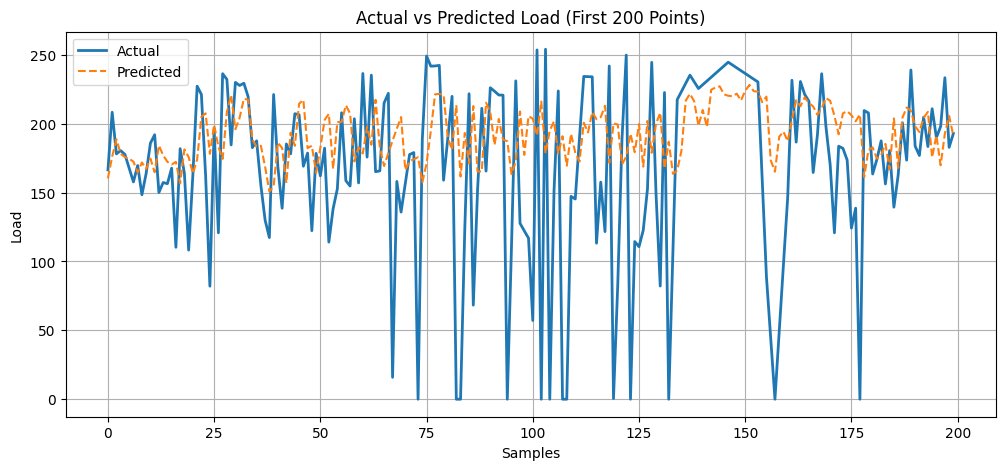

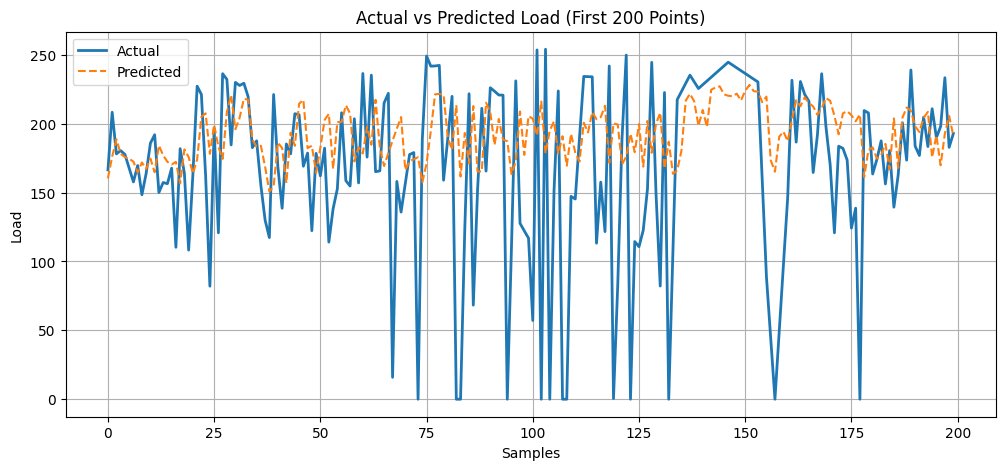

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(y_test_pred[:200], label="Predicted", linestyle="--")
plt.title("Actual vs Predicted Load (First 200 Points)")
plt.xlabel("Samples")
plt.ylabel("Load")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(y_test_pred[:200], label="Predicted", linestyle="--")
plt.title("Actual vs Predicted Load (First 200 Points)")
plt.xlabel("Samples")
plt.ylabel("Load")
plt.legend()
plt.grid()
plt.show()


In [24]:
from google.colab import files
df.to_csv("cleaned_load_dataset.csv", index=False)
files.download("cleaned_load_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>